In [54]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
# import timeit
from scipy.integrate import odeint
from scipy import stats
from matplotlib.ticker import FormatStrFormatter
import modelSystems as ms
from EDMtoolkit import *
from modelSystems import *

%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Xr = ms.generateTimeSeriesContinuous('Lorenz', np.array([1,5,17]))
# c = lambda t: 2+2*t/256+np.sin(t)
# Xr = generateTimeSeriesContinuous('RosslerP', np.array([1,1,1]), nsargs=(c,), end=256, tlen = 1024, reduction = 4)

In [79]:
nyears = 1

settlingTime = 2 ** 10
tlen = 2 ** 8
end = 2**11 # (3.498901098901099 / (12*reduction)) * tlen # 2**3
reduction = 2 ** 0
trainToTest = 0.80 # between 0 and 1

tr = np.linspace(0, end, num=tlen)
t = tr

# MAKE SURE TO UPDATE THE DIMENSION WHEN SWITCHING ATTRACTORS
dim = 1
ndrivers = 1

# t0 = np.array([0.34])
# t0 = np.ones(3) * 3# np.array([0,5,15])# np.ones(dim) * 0.3333 # np.array([0,5,15]) * 1 # np.zeros(dim)
# 
# t0 = np.ones(5)
# t0[0] += 0.1
# t0 = np.array([0,5,15])

In [80]:
""" INITIAL CONDITIONS """
# x0 = np.array([3,250])
# x0 = np.array([0.49])
x0 = np.array([0.1,0.4,9])

# m = 50
# x0 = np.ones(m) * (np.pi ** -1)
# x0[0] += 0.2
# x0[1] += 0.3
# x0 = np.array([1,5,9],dtype=float)

""" DRIVERS """
# Gmax = lambda t: 0.7 # +0.5*t/tlen
# r = lambda t: 3 - 0.5 * t / tlen
# m = lambda t: 0.3
b1 = lambda t: 2 + 4.5 * t / end

""" GENERATE TS """
# Xr = generateTimeSeriesContinuous("HastingsPowell", x0, tlen=tlen, end=end, reduction=reduction, settlingTime=settlingTime)
Xr = standardize(generateTimeSeriesContinuous('HastingsPowellP', x0, nsargs=(b1,), end=end, tlen = tlen, reduction = reduction, settlingTime=settlingTime)[:,0,None])
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturation, x0, settlingTime=30, tlen=tlen)
# Xc = generateTimeSeriesDiscrete(DensityDependentMaturationP, x0, settlingTime=30, tlen=tlen, nsargs=(Gmax,))
# Xr = Xc[:,1,None]
# Xr = generateTimeSeriesDiscrete("LogisticP", x0, tlen=tlen, nsargs=(r,), settlingTime=settlingTime)
# Xr = generateTimeSeriesDiscrete("LogisticIslandsP", x0, nsargs=(r, m), tlen=tlen, settlingTime=settlingTime)[:,4,None]

In [81]:
"""
fig, ax = plt.subplots(1, figsize=(6,4))
ax.scatter(Xc[:,1], Xc[:,0])
ax.set_xlabel("Juveniles")
ax.set_ylabel("Adults")

# ax[1].plot(Xr[::5,1])
# ax[1].set_ylabel("Juveniles")
# ax[2].plot(Xr[::5,0])
# ax[2].set_ylabel("Adults")
plt.tight_layout()
plt.show()
"""

'\nfig, ax = plt.subplots(1, figsize=(6,4))\nax.scatter(Xc[:,1], Xc[:,0])\nax.set_xlabel("Juveniles")\nax.set_ylabel("Adults")\n\n# ax[1].plot(Xr[::5,1])\n# ax[1].set_ylabel("Juveniles")\n# ax[2].plot(Xr[::5,0])\n# ax[2].set_ylabel("Adults")\nplt.tight_layout()\nplt.show()\n'

In [82]:
# poincareT(Xc[:,1],xlabel="Juveniles(t)", ylabel="Juveniles(t-1)")

In [83]:
# FROM DATA

"""
file = "GPDD.csv"
data = pd.read_csv(file,encoding="utf-8",na_filter=False)
states = data.to_numpy()

Xr = np.log(states[:,2,None]+1)
tr = states[:,3] - np.min(states[:,3])
tlen = states.shape[0]
"""
# END FROM DATA

'\nfile = "GPDD.csv"\ndata = pd.read_csv(file,encoding="utf-8",na_filter=False)\nstates = data.to_numpy()\n\nXr = np.log(states[:,2,None]+1)\ntr = states[:,3] - np.min(states[:,3])\ntlen = states.shape[0]\n'

In [84]:

""" UPDATE DRIVERS HERE """

digiDrivers = [b1]

"""
gtsr = np.zeros((Xr.shape[0], ndrivers))
for ind in range(len(digiDrivers)):
    tmp = np.fromfunction(lambda i : digiDrivers[ind](i), (Xr.shape[0],) , dtype = float)# time series of gmax
    gtsr[:,ind] = tmp
"""
# gtsr = h2(t)
gtsr = b1(t) # driverArray
# gtsr = c(t)

<IPython.core.display.Javascript object>


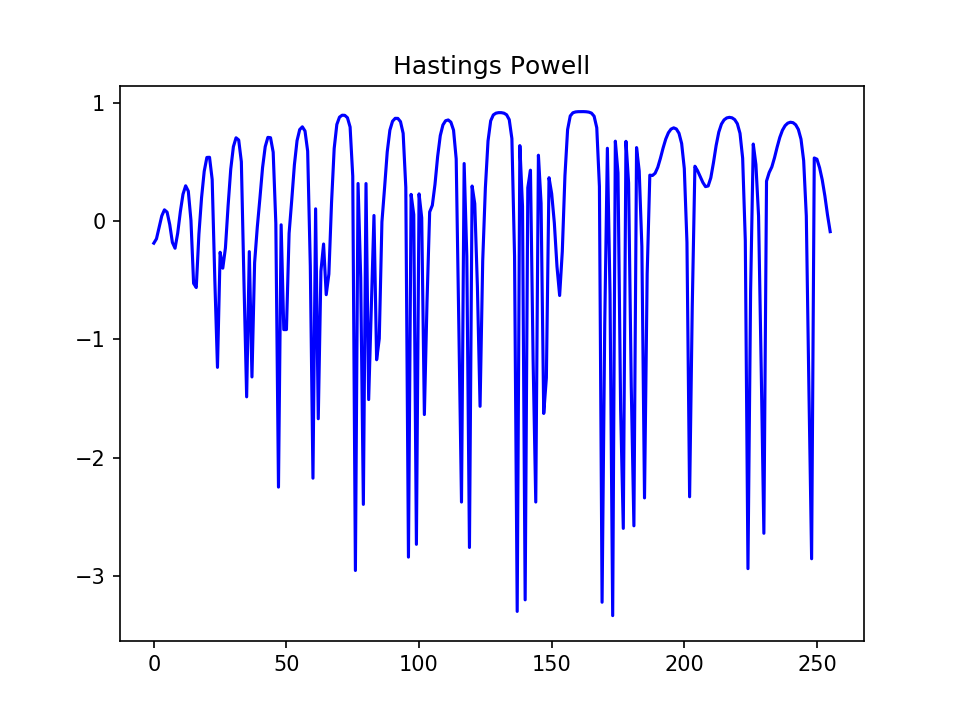

<IPython.core.display.Javascript object>


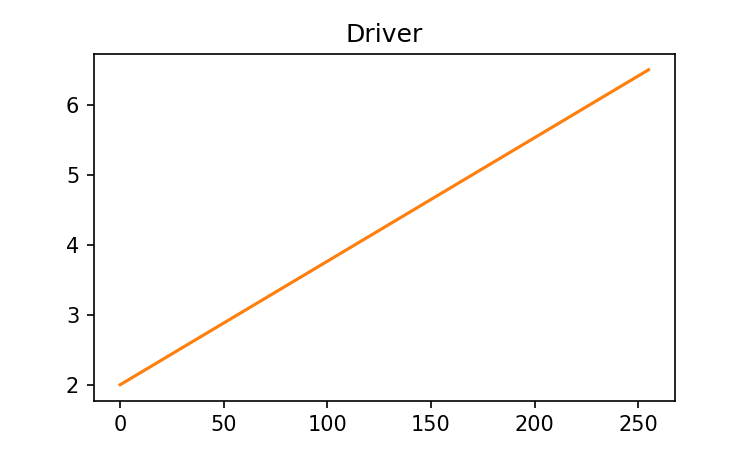

In [85]:
fig2 = plt.figure(2)

if dim == 1:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],"b") # states
elif dim == 2:
    ax2 = plt.subplot()
    ax2.plot(Xr[:,0],Xr[:,1])
else:
    ax2 = fig2.gca(projection="3d")
    ax2.plot(Xr[:,0],Xr[:,1],Xr[:,2], linewidth=1)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_zticks([])
    ax2.set_xlabel("x(t)")
    ax2.set_ylabel("y(t)")
    ax2.set_zlabel("z(t)")
    
ax2.set_title("Hastings Powell")
    
""" 
ax2 = fig2.gca(projection="3d")
ax2.plot(t[settlingTime:],Xr[:,0],Xr[:,1])
ax2.set_xlabel("Time")
ax2.set_ylabel("Species 1 (standardized)")
ax2.set_zlabel("Species 2 (standardized)")
"""
# ax2.set_title("Rosenzweig MacArthur")
plt.savefig("Raw Data")

if dim != 1:
    figTS, axTS = plt.subplots(dim,figsize=(5,dim*3))
    axTS[0].set_title("Cross section Time Series")
    for i in range(dim):
        axTS[i].set_title("Index: {ind}".format(ind=i))
        axTS[i].plot(Xr[:,i])

plt.savefig("Individual Dimensions")
        
if ndrivers != 0:
    figD, axD = plt.subplots(ndrivers, figsize=(5,ndrivers*3))
    if ndrivers == 1:
        axD.set_title("Driver")
        axD.plot(gtsr, c="tab:orange")
    else:
        axD[0].set_title("Driver(s)")
        for d in range(ndrivers):
            axD[d].plot(gtsr[:,d], c="tab:orange")
            
    plt.savefig("Drivers")
        
plt.show()

In [46]:
Xr.shape

(256, 1)

<IPython.core.display.Javascript object>


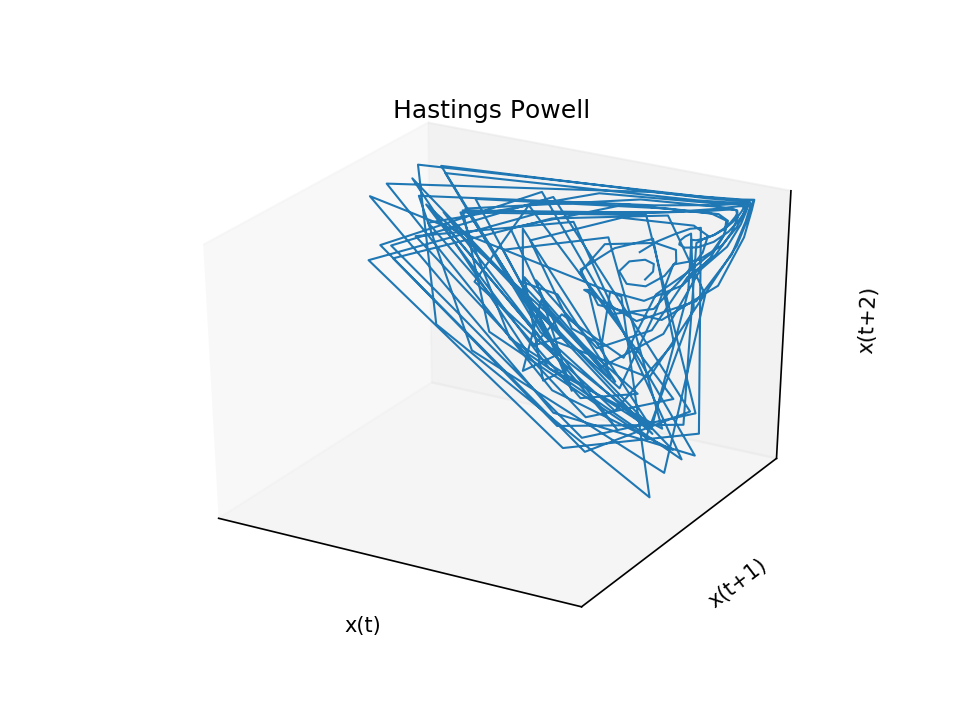

In [86]:
poincare3d(Xr[:,0,None], title="Hastings Powell", scatter=False, step=1)

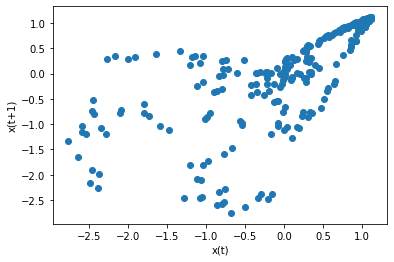

In [48]:
poincare2d(Xr, step = 1)

<IPython.core.display.Javascript object>


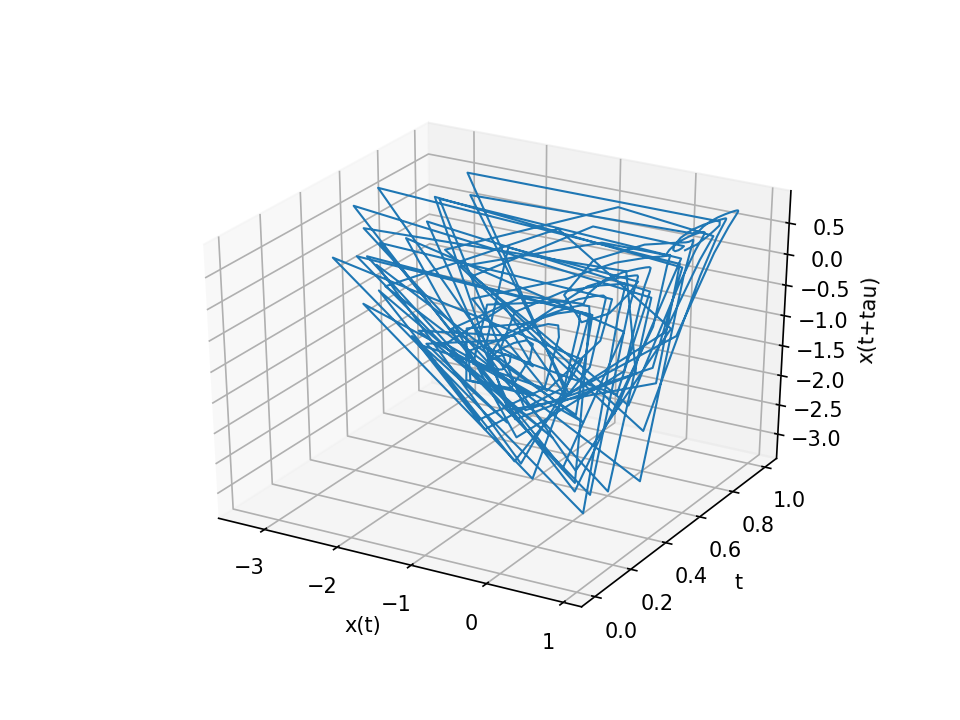

In [87]:
poincareT(Xr,step=1, scatter=False)

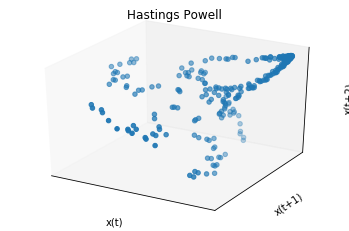

In [50]:
poincare3d(Xr, title="Hastings Powell")

<IPython.core.display.Javascript object>


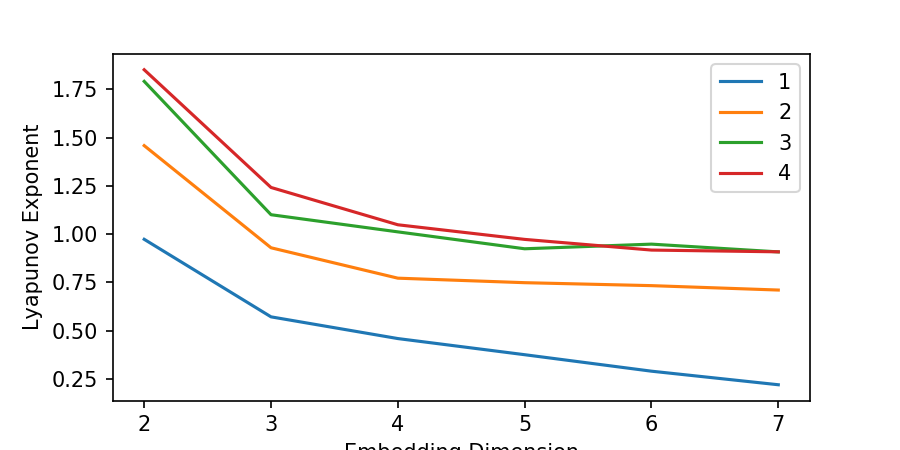

In [88]:
FNNplot(Xr, 5, 4)

In [105]:
predictionHorizon = 1
numLags = 1
lagStep = 1
maxLags = 5

In [132]:
thetaNS, deltaNS, errNS, lagsNS, thetaS, errS, lagsS = optimizationSuite(Xr, tr, predictionHorizon, maxLags, lagStep)

[1.1 0. ]
234.46985367867993
[2.31 0.25]
188.2882176700519
[3.641 0.525]
152.10072432241
[2.9755 0.8275]
149.9886615401649
[3.30825 0.67625]
150.1142423643899
[3.674275 0.751875]
149.73519576754762
[3.4912625 0.7140625]
149.85943283777644
[3.28994875 0.67246875]
149.74870925254118
[3.39060563 0.69326563]
149.7391385910902
[3.34027719 0.68286719]
149.72938092662412
[3.36544141 0.68806641]
149.73061883048956
[3.3528593  0.69378555]
149.72909136356955
[3.35915035 0.69092598]
149.7290280291234
[3.36607051 0.68778045]
149.72894882477928
[3.36261043 0.68935321]
149.72911770421953
[3.35880434 0.68856683]
149.728999962238
[3.36070739 0.68770181]
149.7291162842905
[3.36280074 0.68813432]
149.729171516475
[3.36175406 0.68861008]
149.72910310943632
[3.3622774 0.6883722]
149.72906984006394
[1.1]
234.46985367867993
[2.31]
188.2882176700519
[3.641]
178.14711780428533
[5.1051]
175.58862171658402
[4.37305]
176.40737723773907
[3.567795]
175.80967811818988
[3.9704225]
175.60483777900674
[3.76910875]
175

In [133]:
# thetaBestNS, deltaBestNS, lagBestNS, errorNS, landNS = NSMapOptimize(Xr, tr, predictionHorizon, maxLags, lagStep, thetaVals, deltaVals, returnLandscape=True)

In [134]:
# thetaBestS, lagBestS, errorS, landS = SMapOptimize(Xr, tr, predictionHorizon,maxLags,lagStep, thetaVals, returnLandscape=True)

In [135]:
""" COMPUTE DOFS """

Xn, Yn, txn = delayEmbed(Xr, predictionHorizon, lagsNS, lagStep, t=t)
dofNS = dofestimation(Xn, Yn, txn, thetaNS, deltaNS)

Xs, Ys, txs = delayEmbed(Xr, predictionHorizon, lagsS, lagStep, t=t)
dofS = dofestimation(Xs, Ys, txs, thetaNS, 0)

In [136]:
predictedTSNS = leaveOneOut(Xn, Yn, txn, thetaNS, deltaNS)
predictedTSS = leaveOneOut(Xs, Ys, txs, thetaNS, 0)

In [137]:
MSENS = np.mean((predictedTSNS - Yn) ** 2 )
MSES = np.mean((predictedTSS - Ys) ** 2 )

<IPython.core.display.Javascript object>


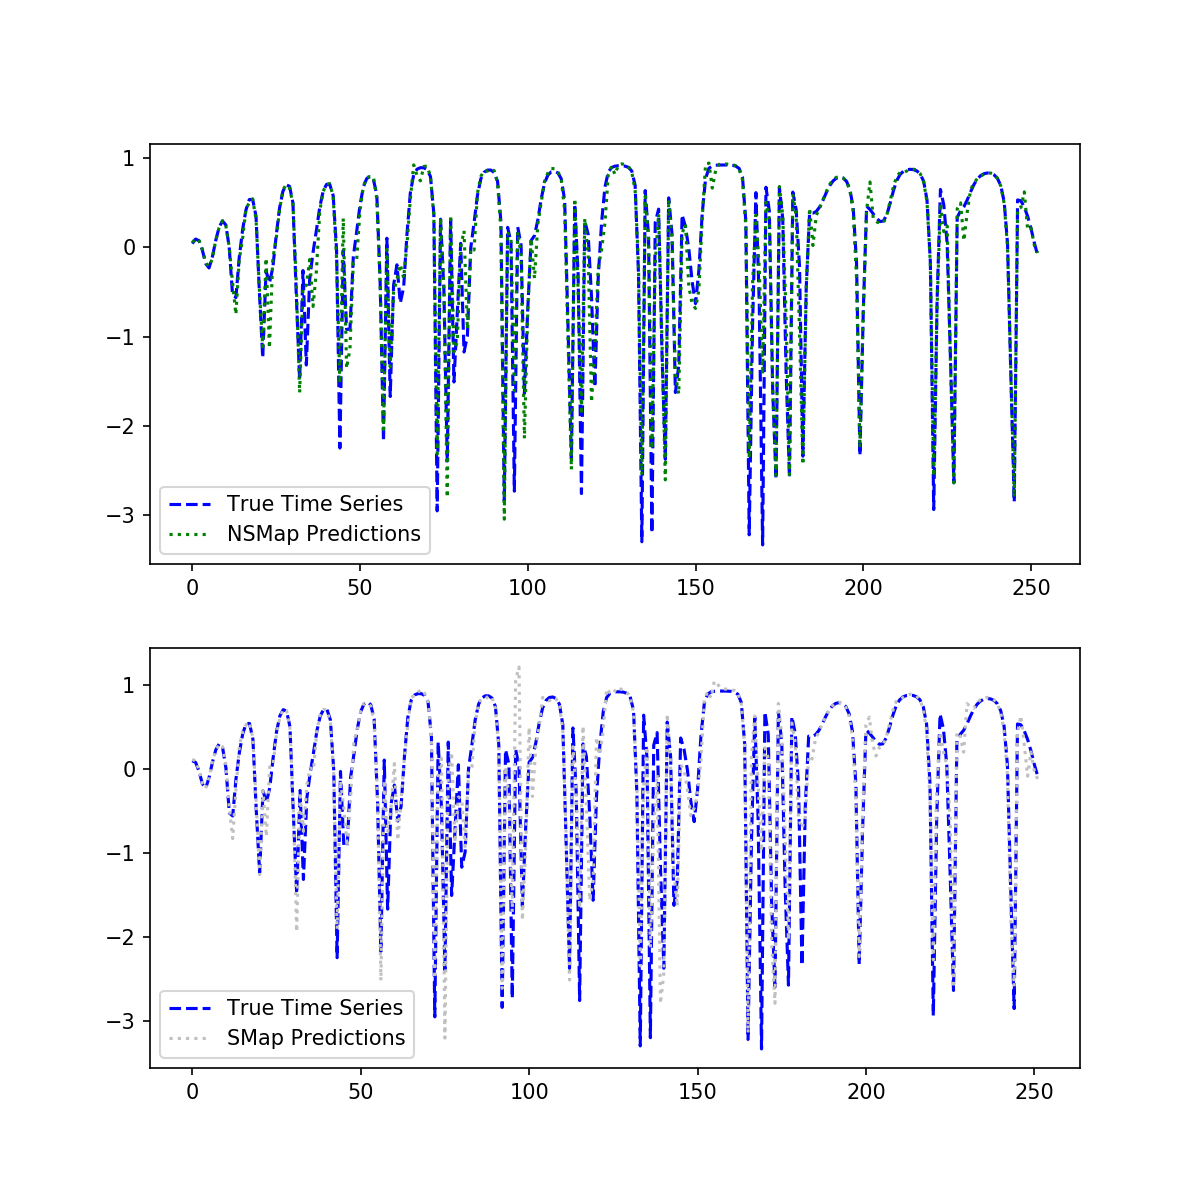

In [138]:
figLOU, axLOU = plt.subplots(2, figsize=(8,8))
axLOU[0].plot(Yn, c="blue", linestyle="dashed", label="True Time Series")
axLOU[0].plot(predictedTSNS, c="green", linestyle="dotted", label="NSMap Predictions")
axLOU[0].legend()

axLOU[1].plot(Ys, c="blue", linestyle="dashed", label="True Time Series")
axLOU[1].plot(predictedTSS, c="silver", linestyle="dotted", label="SMap Predictions")
axLOU[1].legend()
plt.show()

In [ ]:
# functionSurfaceNSMap(Xr, predictionHorizon, thetaBestNS, deltaBestNS, 15)

In [139]:
# functionSurfaceSMap(Xr, predictionHorizon, thetaBestS, 15)

In [141]:
### SUMMARY ###

print(f"NSMap -- theta: {thetaNS:.3f}, delta: {deltaNS:.3f}, Min Error: {errNS:.3f}, Optimal Embedding Dimension: {lagsNS+2}, MSE: {MSENS}, 10% Weight Dropoff: {(1-deltaNS)**(0.1)}")
print(f"SMap -- theta: {thetaS:.3f}, Min Error: {errS:.3f}, Optimal Embedding Dimension: {lagsS+2}, MSE: {MSES}")

print(f"Improvement of NSMap: {errS/errNS:.3f}")

print(f"NSMap dof: {dofNS:.3f}")
print(f"SMap dof: {dofS:.3f}")

AkaikeTest(errNS, errS, dofNS, dofS, Xr.shape[0])

NSMap -- theta: 8.122, delta: 0.999, Min Error: 19.880, Optimal Embedding Dimension: 4, MSE: 0.07865014624600333, %10 Weight Dropoff: 0.49095683440579835
SMap -- theta: 7.082, Min Error: 34.650, Optimal Embedding Dimension: 5, MSE: 0.13982823326384328
Improvement of NSMap: 1.743
NSMap dof: 195.525
SMap dof: 163.069
Probability SMap beats NSMap:  1.6247746644883962e-17


In [ ]:
# fix, ax = plt.subplots(1)
# ax.imshow(landNS[1:,1:,2])

In [142]:
deltaNS

0.9991863584838867